# Reading and editing a topography

The topography/bathymetry is extracted from a NetCDF file.     
Adapted topographies:
* General Bathymetric Chart of the Oceans ([GEBCO](https://www.gebco.net/))
* [EMODnet Bathymetry](http://www.emodnet-bathymetry.eu)
* Other topographies can be used as long as they define the netCDF variables `lon`, `lat` and `bat` (positive above sea-level and negative below, in `DIVAnd` however, the convention is that `z` is positive in sea water).

This notebook illustrates how the land-sea mask can be changed (to exclude for example a lake).

In [1]:
using PyPlot
using divand

EMODnet Bathymetry is a quite file (~1GB) that can be obtained from the bathymetry portal: http://portal.emodnet-bathymetry.eu/?menu=19. In the present notebook we will work with the GEBCO bathymetry with a resolution that has been decreased.

Note that an extremely fine bathymetry is not necessary for large regions of interest.

## Data download and domain selection
We create a domain encompassing the north of Corsica.

In [2]:
dx = dy = 0.125
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6

# https://b2drop.eudat.eu/s/ACcxUEZZi6a4ziR/download  gebco_30sec_4.nc
# https://b2drop.eudat.eu/s/x83MSV8yUF934bL/download  gebco_30sec_8.nc
# https://b2drop.eudat.eu/s/o0vinoQutAC7eb0/download  gebco_30sec_16.nc

bathname = "gebco_30sec_8.nc"

if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/x83MSV8yUF934bL/download",bathname)
else
    info("Bathymetry file already downloaded")
end

bathisglobal = true

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.7M  100 55.7M    0     0  15.8M      0  0:00:03  0:00:03 --:--:-- 15.8M


true

We have two main tools to load the bathymetry:
1. `divand.extract_bath` loads the bathymetry at the resolution defined in the netCDF file while 
2. `divand.load_bath` reduces the resolution to match the resolution of the analysis.

### Extract bathymetry

In [3]:
?extract_bath

search: extract_bath



```
bx,by,b = divand.extract_bath(bath_name,isglobal,xi,yi)
```

Extract the bathymetry from the NetCDF file `bathname`. The parameter `isglobal`  is true if the NetCDF file covers the whole globe and thus the last longitude  point can be considered to be right next to the first longitude point. `xi` and `yi` are vectors defining the bounding box of the data. No  interpolation is performed.

b is positive in the water and negative in the air.


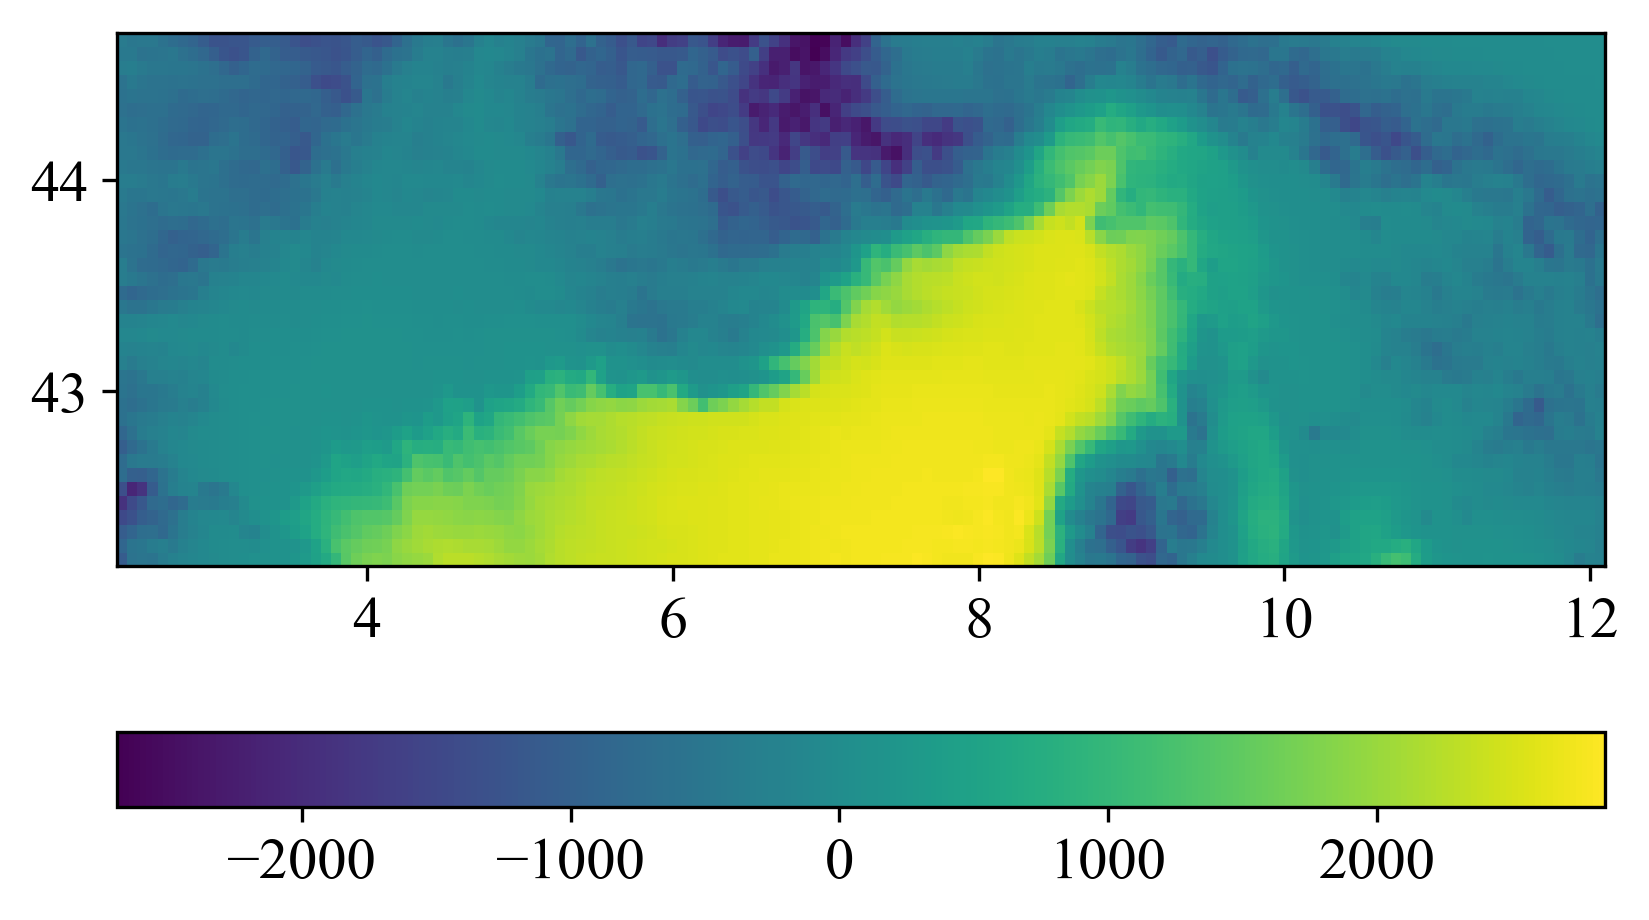

size(b) = (147, 39)


In [5]:
bx,by,b = extract_bath(bathname,true,lonr,latr)

pcolor(bx,by,b'); colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

@show size(b);

### Load bathymetry
With a change of its original resolution

In [6]:
?load_bath

search: load_bath



```
xi,yi,bath = divand.load_bath(bath_name,isglobal,xi,yi)
```

Load the bathymetry from the NetCDF file `bathname`. The parameter `isglobal` is true if the NetCDF file covers the whole globe and  thus the last longitude point can be considered to be right next to the first longitude point. `xi` and `yi` is a vector of the longitude and latitude grid onto which the bathymetry should be  interpolated.


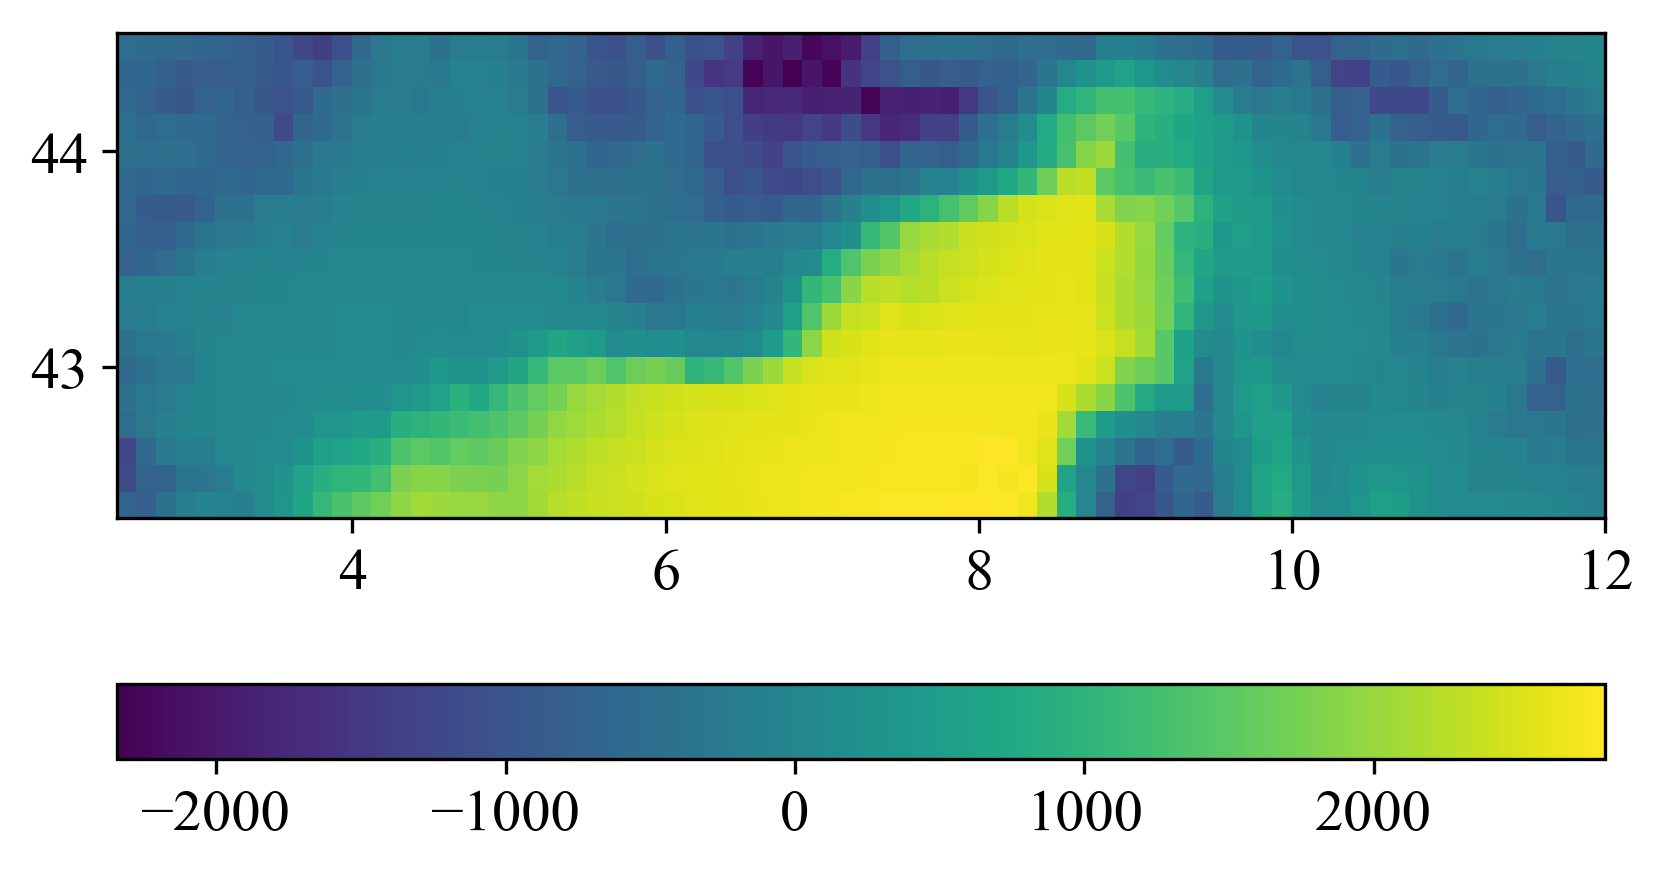

In [7]:
bx,by,b = load_bath(bathname,true,lonr,latr)

pcolor(bx,by,b'); 
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

#@show size(b)

## Mask creation
We start by defining the mask as a 3D matrix containing only `False`, then we set the values to `True` when the actual depth is deeper than the selected values stored in the vector `depthr`.

In [8]:
depthr = [0,10,20,500]
mask = falses(size(b,1),size(b,2),length(depthr))

for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
    
end

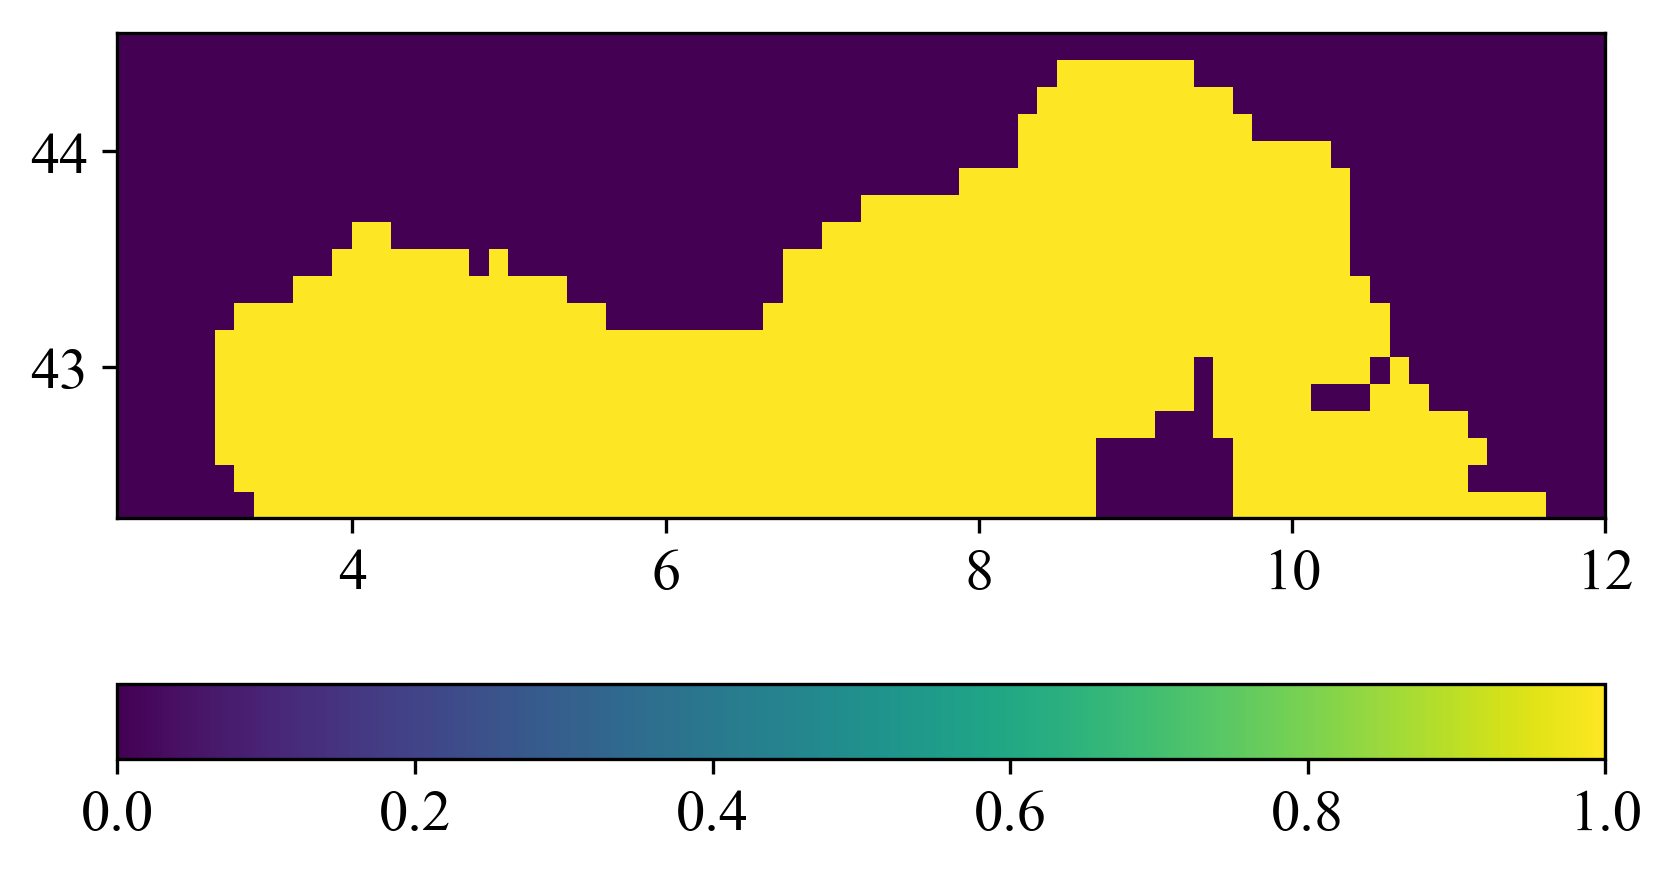

In [9]:
pcolor(bx,by,Float64.(mask[:,:,1])'); colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

## Mask editing
### Create an artificial island.

In [10]:
mask[63,8,:] = false

false

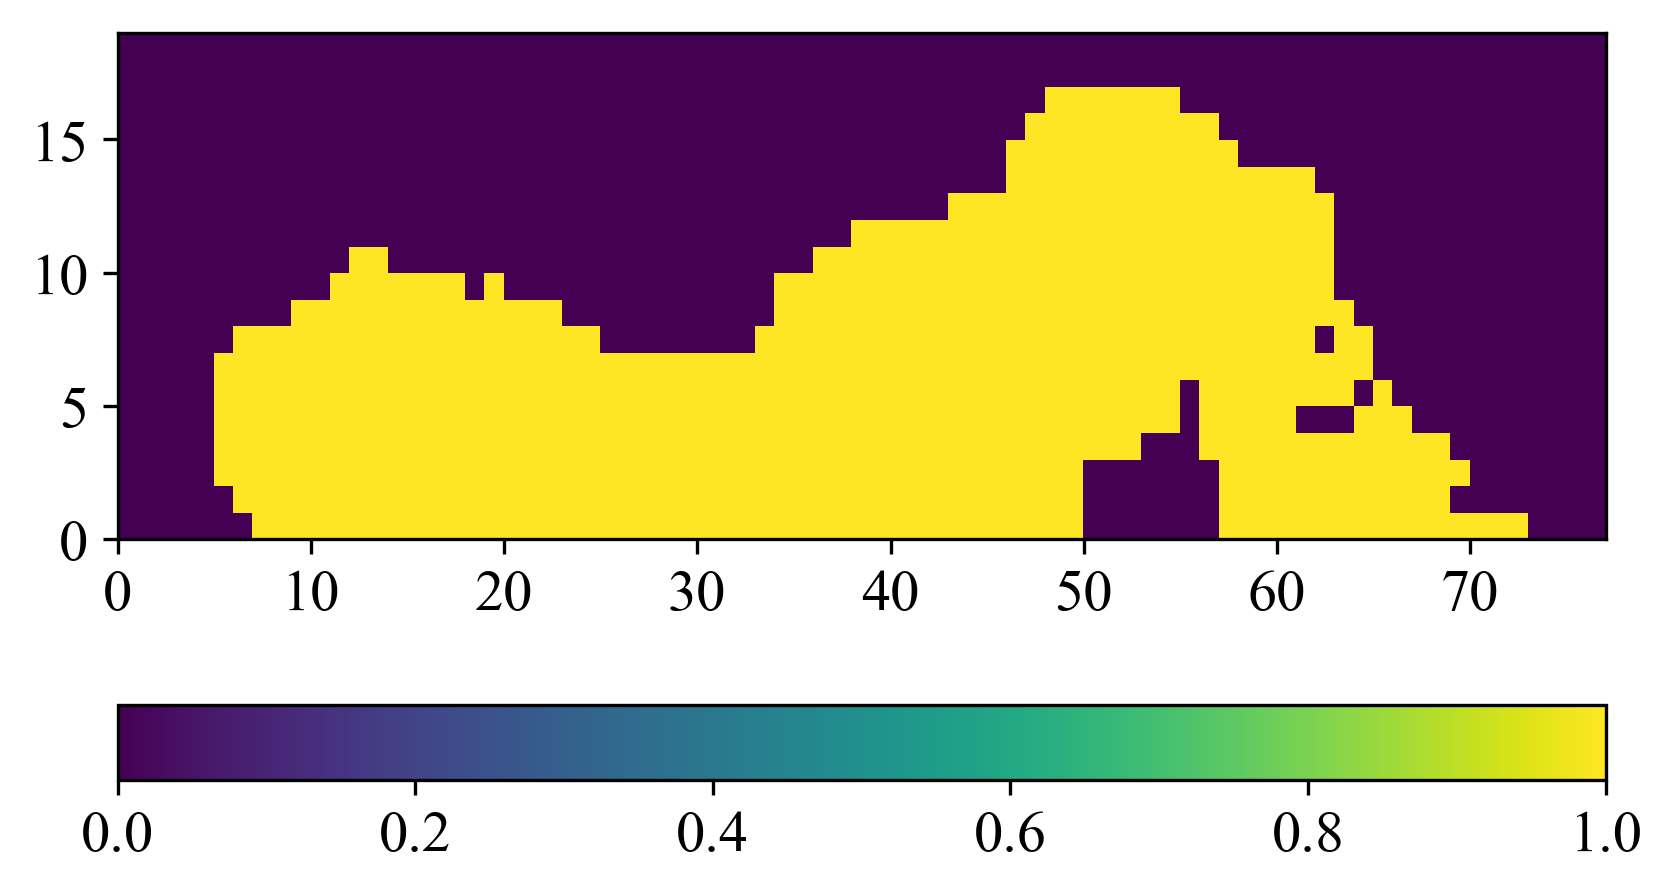

In [11]:
pcolor(Float64.(mask[:,:,1])'); colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(43.5 * pi/180))

### Remove an island

In [12]:
mask[48:59,1:10,:] = true

true

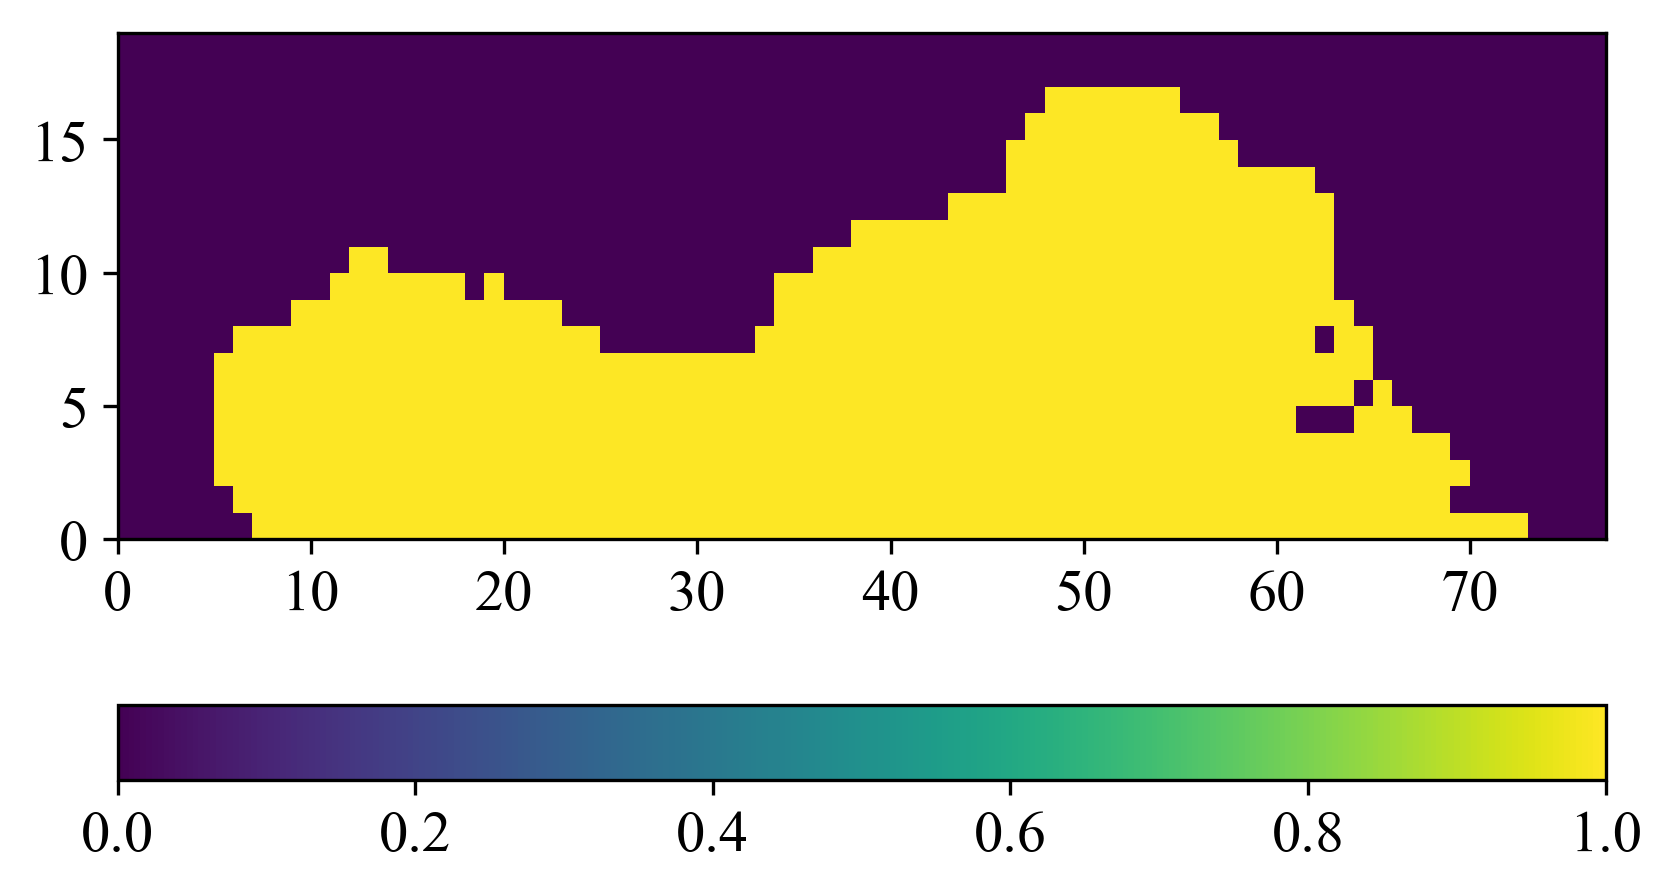

In [14]:
pcolor(Float64.(mask[:,:,1])'); colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(43.5 * pi/180))

## Exercice
In the same domain, create a barrier that separate the domain in two parts following a longitude of 30°E.